In [ ]:
import torch
from string import punctuation
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.lm import Vocabulary
from nltk import pos_tag
import pandas as pd
import numpy as np
import string
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple
import spacy

import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

spacy.load('en_core_web_sm')

!unzip liar_dataset.zip
dataset_columns = ['id','label','text','subject','speaker','job title','state info','party','barely true','false','half true','mostly true','pants on fire','context']
train = pd.read_csv('train.tsv',sep='\t',header=None, names = dataset_columns)
test = pd.read_csv('test.tsv',sep='\t',header=None, names = dataset_columns)
val = pd.read_csv('valid.tsv',sep='\t',header=None, names = dataset_columns)

def handle_nas(df):
  # get all indices where job title and state info are nas:
  jt_indices = df[df["job title"].isna()].index
  si_indices = df[df["state info"].isna()].index

  df.loc[jt_indices,"job title"] = "unk"
  df.loc[si_indices,"state info"] = "unk"

  # dropping all other rows with nas
  df.dropna(inplace=True)
  df = df.reset_index(drop=True)

  return df

train = handle_nas(train)
test = handle_nas(test)
val = handle_nas(val)

def get_meta_data(df, df_val, df_test):
  concatenated_df = pd.concat([df,df_val,df_test])
  print(concatenated_df)
  # handling meta data
  # not storing anything in vocab
  top_categories = df['speaker'].value_counts().nlargest(20).index
  print("speaker top categories:",df['speaker'].value_counts().nlargest(20))
  concatenated_df['speaker'] = concatenated_df['speaker'].where(concatenated_df['speaker'].isin(top_categories), 'Other')
  speaker_ohe = pd.get_dummies(concatenated_df['speaker']).to_numpy()
  print(speaker_ohe.shape)

  # largest category is unk which we imputed. To ensure there is no bias, it is
  # not taken into consideration
  top_categories = df['job title'].value_counts().nlargest(21)[1:].index
  print("job title top categories:",df['job title'].value_counts().nlargest(21))
  concatenated_df['job title'] = concatenated_df['job title'].where(concatenated_df['job title'].isin(top_categories), 'Other')
  job_title_ohe = pd.get_dummies(concatenated_df['job title']).to_numpy()
  print(job_title_ohe.shape)

  # largest category is unk which we imputed. To ensure there is no bias, it is
  # not taken into consideration
  top_categories = df['state info'].value_counts().nlargest(21)[1:].index
  print("state info top categories:",df['state info'].value_counts().nlargest(21))
  concatenated_df['state info'] = concatenated_df['state info'].where(concatenated_df['state info'].isin(top_categories), 'Other')
  state_info_ohe = pd.get_dummies(concatenated_df['state info']).to_numpy()
  print(state_info_ohe.shape)

  top_categories = df['party'].value_counts().nlargest(20).index
  print("party top categories:",df['party'].value_counts().nlargest(20))
  concatenated_df['party'] = concatenated_df['party'].where(concatenated_df['party'].isin(top_categories), 'Other')
  party_ohe = pd.get_dummies(concatenated_df['party']).to_numpy()
  print(party_ohe.shape)


  top_categories = (
      df['subject'].str.split(',', expand=True).stack()
      .value_counts().nlargest(20).index
  )

  subjects = concatenated_df['subject'].apply(lambda x: [cat for cat in x.split(',') if cat in top_categories])
  subjects = pd.get_dummies(subjects.apply(pd.Series).stack()).sum(level=0)
  print("subjects top categories:",subjects.columns)
  subject_ohe = subjects.to_numpy()
  print(subject_ohe.shape)

  counts = concatenated_df[['barely true','false','half true','mostly true','pants on fire']].to_numpy()
  print(counts.shape)

  meta_data = np.hstack((speaker_ohe,job_title_ohe,state_info_ohe,party_ohe))
  meta_data_train = meta_data[:len(df)]
  meta_data_val = meta_data[len(df):len(df)+len(df_val)]
  meta_data_test = meta_data[len(df)+len(df_val):]
  print(meta_data.shape)

  return meta_data_train,meta_data_val,meta_data_test

meta_data_train,meta_data_val,meta_data_test = get_meta_data(train,val,test)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Archive:  liar_dataset.zip
replace README? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: README                  
  inflating: test.tsv                
  inflating: train.tsv               
  inflating: valid.tsv               
              id        label  \
0      2635.json        false   
1     10540.json    half-true   
2       324.json  mostly-true   
3      1123.json        false   
4      9028.json    half-true   
...          ...          ...   
1245   7334.json    half-true   
1246   9788.json  barely-true   
1247  10710.json  barely-true   
1248   3186.json  barely-true   
1249   6743.json        false   

                                                   text  \
0     Says the Annies List political group supports ...   
1     When did the decline of coal start? It started...   
2     Hillary Clinton agrees with John McCain "by vo...   
3     Health care reform legislation is likely to ma...   
4     The economic turnaround started at the end of ...   
...           

<ipython-input-5-fd6e2516fa58>:101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  subjects = pd.get_dummies(subjects.apply(pd.Series).stack()).sum(level=0)


subjects top categories: Index(['candidates-biography', 'crime', 'economy', 'education', 'elections',
       'energy', 'environment', 'federal-budget', 'foreign-policy', 'guns',
       'health-care', 'history', 'immigration', 'job-accomplishments', 'jobs',
       'legal-issues', 'military', 'state-budget', 'taxes', 'workers'],
      dtype='object')
(8305, 20)
(12660, 5)
(12660, 84)


<ipython-input-5-fd6e2516fa58>:101: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  subjects = pd.get_dummies(subjects.apply(pd.Series).stack()).sum(level=0)


In [ ]:
meta_data_train.shape,meta_data_val.shape,meta_data_test.shape

((10138, 84), (1272, 84), (1250, 84))

In [ ]:

one_hot_encoder = OneHotEncoder()
label_encoder = LabelEncoder()

class LiarDataset(torch.utils.data.Dataset):
  def __init__(self,data,meta_data,all_labels = True, vocab = None, POS_vocab = None, DEP_vocab = None, build_vocab = True):
    self.data = data
    self.all_labels = all_labels
    # get labels
    if self.all_labels == True:
      label_encoder = LabelEncoder()
      self.labels = label_encoder.fit_transform(self.data["label"])
    else:
      self.data["label"] = self.data["label"].replace(['half-true', 'mostly-true', 'true'], 'true')
      self.data["label"] = self.data["label"].replace(['false', 'barely-true', 'pants-fire'], 'false')
      label_encoder = LabelEncoder()
      self.labels = label_encoder.fit_transform(self.data["label"])

    self.stopwords = nltk.corpus.stopwords.words("english")
    self.lemmatizer = nltk.stem.WordNetLemmatizer()
    self.vocab = vocab
    self.POS_vocab = POS_vocab
    self.build_vocab = build_vocab
    self.tokenizer = get_tokenizer('basic_english')
    self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.max_len = 18
    self.meta_data = meta_data

  def __getitem__(self,idx):
    s = self.data["text"][idx]
    s = s.lower()
    s = ''.join([c for c in s if c not in string.punctuation])
    # tokenize text
    s = nltk.word_tokenize(s)
    # remove stop words
    s = [word for word in s if word not in self.stopwords]
    pos = pos_tag(s)
    pos = [tup[1] for tup in pos]
    # perform lemmatization
    s = [self.lemmatizer.lemmatize(word) for word in s]
    s = ' '.join(s)
    # handle meta data

    sample = {"Text":s,"POS":pos,"Meta":self.meta_data[idx],"Label":self.labels[idx]}
    if self.build_vocab == False:
      sample["Text"] = torch.tensor(self.vocab(self.tokenizer(sample["Text"])), dtype=torch.int)
      sample["POS"] = torch.tensor(self.POS_vocab(sample["POS"]), dtype=torch.int)
      sample["Meta"] = torch.tensor(sample["Meta"], dtype=torch.float)
      sample = self.preprocessing(sample)
    return sample

  def __len__(self):
    return len(self.data)

  def preprocessing(self,sample):
    if len(sample["Text"]) > self.max_len:
      sample["Text"] = sample["Text"][:self.max_len].to(torch.int)
      sample["POS"] = sample["POS"][:self.max_len].to(torch.int)
    else:
      sample["Text"] = torch.cat((sample["Text"],torch.tensor([0 for i in range(len(sample["Text"]),self.max_len)])), dim = 0).to(torch.int)
      sample["POS"] = torch.cat((sample["POS"],torch.tensor([0 for i in range(len(sample["POS"]),self.max_len)])), dim = 0).to(torch.int)

    for key in sample:
      if torch.is_tensor(sample[key]):
        sample[key] = sample[key]
      else:
        sample[key] = torch.tensor(sample[key])
    return sample

train_dataset = LiarDataset(train,meta_data_train)
tokenizer = get_tokenizer('basic_english')
def get_tokens(data_iter):
  for sample in range(len(data_iter)):
    yield tokenizer(data_iter[sample]["Text"])
vocab = build_vocab_from_iterator(get_tokens(train_dataset), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

def get_POS_tokens(data_iter):
  for sample in range(len(data_iter)):
    yield data_iter[sample]["POS"]
POS_vocab = build_vocab_from_iterator(get_POS_tokens(train_dataset), specials=['<unk>'])
POS_vocab.set_default_index(POS_vocab['<unk>'])

print("vocab sizes")
print("word:",len(vocab),"POS:",len(POS_vocab))


train_dataset = LiarDataset(train,meta_data_train, vocab = vocab, POS_vocab=POS_vocab, build_vocab = False)
test_dataset = LiarDataset(test,meta_data_test, vocab = vocab, POS_vocab=POS_vocab, build_vocab = False)
val_dataset = LiarDataset(val,meta_data_val, vocab = vocab, POS_vocab=POS_vocab, build_vocab = False)

def custom_collate(batch):
    texts = [item["Text"] for item in batch]
    POS = [item["POS"] for item in batch]
    meta = [item["Meta"] for item in batch]
    labels = [item["Label"] for item in batch]
    # Convert the list of texts and labels to tensors and stack them
    text_tensor = torch.stack(texts)
    POS_tensor = torch.stack(POS)
    meta_tensor = torch.stack(meta)
    label_tensor = torch.stack(labels)
    return {"Text": text_tensor, "POS": POS_tensor,"Meta": meta_tensor,"Label": label_tensor}

batch_size = 4
shuffle = True
num_workers = 4
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)

vocab sizes
word: 11742 POS: 35


In [ ]:
def train_and_evaluate(model, criterion, optimizer, train_dataloader, val_dataloader, test_dataloader, num_epochs):

  train_loss_list = []
  val_loss_list = []
  test_loss_list = []

  train_acc_list = []
  val_acc_list = []
  test_acc_list = []

  for epoch in range(num_epochs):
    if epoch >=1:
      model.train()
      batch_num = 0
      running_loss = 0.0
      running_corrects = 0
      count = 0
      for batch in train_dataloader:
        inputs = batch["Text"].to(device)
        POS = batch["POS"].to(device)
        Meta = batch["Meta"].to(device)
        labels = batch["Label"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs,POS,Meta)
        loss = criterion(outputs, labels)
        loss.backward()
        pred = torch.argmax(outputs,dim = 1)
        optimizer.step()
        running_loss += loss.item()
        running_corrects += torch.sum(pred == labels)
        count += len(pred)
        batch_num += 1
      print(f'[{epoch + 1}] \t train loss:{running_loss / count:.3f} \t train accuracy: {running_corrects / count:.3f} \t count: {count}')
      train_loss_list.append(running_loss / count)
      train_acc_list.append((running_corrects / count).cpu().numpy())


    model.eval()
    batch_num = 0
    running_loss = 0.0
    running_corrects = 0
    count = 0
    for batch in val_dataloader:
      inputs = batch["Text"].to(device)
      POS = batch["POS"].to(device)
      Meta = batch["Meta"].to(device)
      labels = batch["Label"].to(device)
      optimizer.zero_grad()
      outputs = model(inputs,POS,Meta, val = True)
      loss = criterion(outputs, labels)
      pred = torch.argmax(outputs,dim = 1)
      running_loss += loss.item()
      running_corrects += torch.sum(pred == labels)
      count += len(pred)
      batch_num += 1
    print(f'[{epoch + 1}] \t val loss:{running_loss / count:.3f} \t val accuracy: {running_corrects / count:.3f} \t count: {count}')
    val_loss_list.append(running_loss / count)
    val_acc_list.append((running_corrects / count).cpu().numpy())

    model.eval()
    batch_num = 0
    running_loss = 0.0
    running_corrects = 0
    count = 0
    for batch in test_dataloader:
      inputs = batch["Text"].to(device)
      POS = batch["POS"].to(device)
      Meta = batch["Meta"].to(device)
      labels = batch["Label"].to(device)
      optimizer.zero_grad()
      outputs = model(inputs,POS,Meta, val = True)
      loss = criterion(outputs, labels)
      pred = torch.argmax(outputs,dim = 1)
      running_loss += loss.item()
      running_corrects += torch.sum(pred == labels)
      count += len(pred)
      batch_num += 1
    print(f'[{epoch + 1}] \t test loss:{running_loss / count:.3f} \t test accuracy: {running_corrects / count:.3f} \t count: {count}\n')
    test_loss_list.append(running_loss / count)
    test_acc_list.append((running_corrects / count).cpu().numpy())


  print(train_loss_list, train_acc_list)
  print(val_loss_list, val_acc_list)
  print(test_loss_list, test_acc_list)
  # make sure all lists are numpy
  train_loss_list = np.array(train_loss_list)
  train_acc_list = np.array(train_acc_list)
  val_loss_list = np.array(val_loss_list)
  val_acc_list = np.array(val_acc_list)
  test_loss_list = np.array(test_loss_list)
  test_acc_list = np.array(test_acc_list)
  print(train_loss_list, train_acc_list)
  print(val_loss_list, val_acc_list)
  print(test_loss_list, test_acc_list)

  plt.figure(figsize=(12, 6))

  plt.subplot(1, 2, 1)
  plt.plot(train_loss_list, label=' training loss')
  plt.plot(val_loss_list, label='validation loss')
  plt.plot(test_loss_list, label='test loss')
  plt.xlabel('Epochs')
  plt.ylabel('Mean Loss')
  plt.xticks(np.arange(0,num_epochs))
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(train_acc_list, label='training accuracy')
  plt.plot(val_acc_list , label='validation accuracy')
  plt.plot(test_acc_list , label='test accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.xticks(np.arange(0,num_epochs))

  plt.legend()

  plt.tight_layout()
  plt.show()

  model.eval()
  y_pred = np.array([])
  y_true = np.array([])
  for batch in val_dataloader:
    inputs = batch["Text"].to(device)
    POS = batch["POS"].to(device)
    Meta = batch["Meta"].to(device)
    labels = batch["Label"].to(device)
    optimizer.zero_grad()
    outputs = model(inputs,POS,Meta, val = True)
    loss = criterion(outputs, labels)
    pred = torch.argmax(outputs,dim = 1)
    y_pred = np.append(y_pred,pred.cpu().numpy())
    y_true = np.append(y_true,labels.cpu().numpy())

  print(y_pred,y_true)
  print("Classification report of val dataset")
  print(classification_report(y_true=y_true, y_pred=y_pred, zero_division=1))

  model.eval()
  y_pred = np.array([])
  y_true = np.array([])
  for batch in test_dataloader:
    inputs = batch["Text"].to(device)
    POS = batch["POS"].to(device)
    Meta = batch["Meta"].to(device)
    labels = batch["Label"].to(device)
    optimizer.zero_grad()
    outputs = model(inputs,POS,Meta, val = True)
    loss = criterion(outputs, labels)
    pred = torch.argmax(outputs,dim = 1)
    y_pred = np.append(y_pred,pred.cpu().numpy())
    y_true = np.append(y_true,labels.cpu().numpy())

  print(y_pred,y_true)
  print("Classification report of test dataset")
  print(classification_report(y_true=y_true, y_pred=y_pred, zero_division=1))




[1] 	 val loss:0.519 	 val accuracy: 0.175 	 count: 1272
[1] 	 test loss:0.520 	 test accuracy: 0.157 	 count: 1250

[2] 	 train loss:0.582 	 train accuracy: 0.189 	 count: 10138
[2] 	 val loss:0.448 	 val accuracy: 0.219 	 count: 1272
[2] 	 test loss:0.449 	 test accuracy: 0.206 	 count: 1250

[3] 	 train loss:0.498 	 train accuracy: 0.203 	 count: 10138
[3] 	 val loss:0.444 	 val accuracy: 0.193 	 count: 1272
[3] 	 test loss:0.447 	 test accuracy: 0.174 	 count: 1250

[4] 	 train loss:0.467 	 train accuracy: 0.204 	 count: 10138
[4] 	 val loss:0.441 	 val accuracy: 0.202 	 count: 1272
[4] 	 test loss:0.443 	 test accuracy: 0.197 	 count: 1250

[5] 	 train loss:0.455 	 train accuracy: 0.215 	 count: 10138
[5] 	 val loss:0.445 	 val accuracy: 0.209 	 count: 1272
[5] 	 test loss:0.445 	 test accuracy: 0.216 	 count: 1250

[6] 	 train loss:0.450 	 train accuracy: 0.223 	 count: 10138
[6] 	 val loss:0.445 	 val accuracy: 0.200 	 count: 1272
[6] 	 test loss:0.443 	 test accuracy: 0.193 	 c

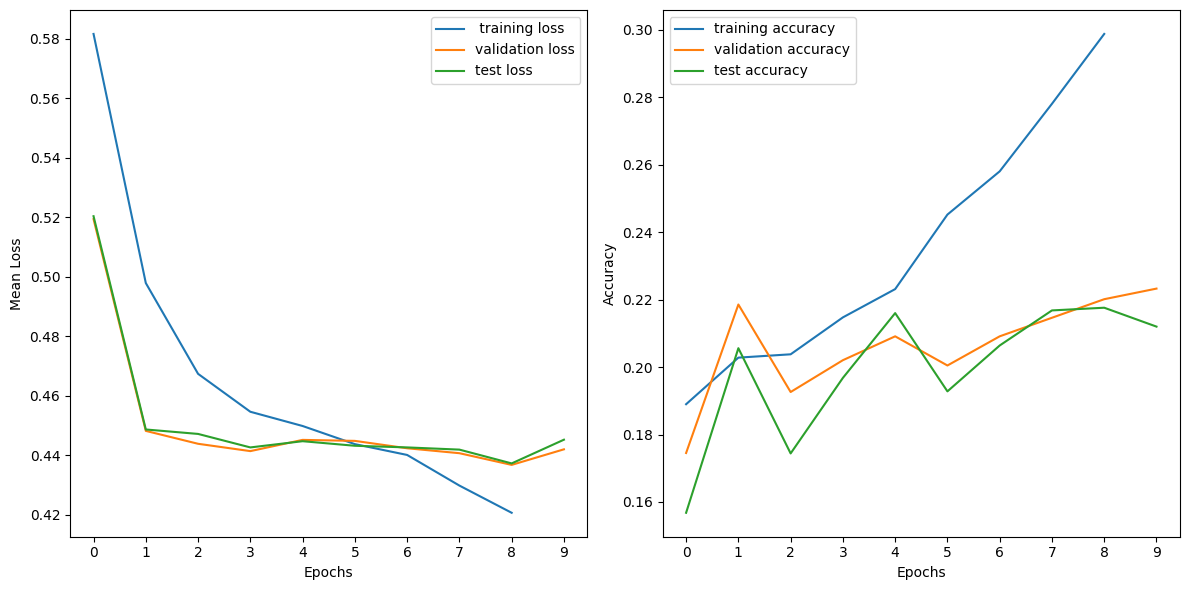

[1. 1. 1. ... 1. 1. 1.] [1. 2. 3. ... 1. 5. 3.]
Classification report of val dataset
              precision    recall  f1-score   support

         0.0       0.19      0.10      0.13       234
         1.0       0.22      0.83      0.35       262
         2.0       0.32      0.03      0.06       247
         3.0       0.29      0.12      0.17       249
         4.0       0.33      0.02      0.03       113
         5.0       0.16      0.02      0.04       167

    accuracy                           0.22      1272
   macro avg       0.25      0.19      0.13      1272
weighted avg       0.25      0.22      0.15      1272

[3. 1. 1. ... 2. 1. 1.] [2. 2. 3. ... 1. 5. 0.]
Classification report of test dataset
              precision    recall  f1-score   support

         0.0       0.22      0.12      0.16       212
         1.0       0.20      0.79      0.32       246
         2.0       0.29      0.03      0.06       260
         3.0       0.25      0.12      0.16       238
         4.0   

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class HybridCNNModel(nn.Module):
  def __init__(self, input_size, input_size_POS, input_size_Meta, embedding_dim, hidden_size, output_size):
    super(HybridCNNModel, self).__init__()
    self.word_embeddings = nn.Embedding(input_size, embedding_dim)
    filter_sizes = [2,3,4]
    self.convs = nn.ModuleList([
      nn.Sequential(
        nn.Conv1d(in_channels=18, out_channels=128, kernel_size=fs),
        nn.ReLU(),
        nn.Dropout(p=0.8)
      ) for fs in filter_sizes
    ])
    self.fc = nn.Linear(len(filter_sizes) * 128, output_size)

  def forward(self, x, POS, Meta, val = False):
    x = self.word_embeddings(x)
    x = [nn.functional.relu(conv(x)) for conv in self.convs]
    x = [nn.functional.max_pool1d(conv, conv.size(2)).squeeze(2) for conv in x]
    x = torch.cat(x, 1)
    x = self.fc(x)
    return x


# Instantiate the model
input_size = len(vocab)
input_size_POS = len(POS_vocab)
input_size_Meta = 84

embedding_dim = 100
hidden_size = 100
output_size = 6
model = HybridCNNModel(input_size, input_size_POS, input_size_Meta, embedding_dim, hidden_size, output_size).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 10

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)

train_and_evaluate(model, criterion, optimizer, train_dataloader, val_dataloader, test_dataloader, num_epochs)

[1] 	 val loss:0.519 	 val accuracy: 0.193 	 count: 1272
[1] 	 test loss:0.528 	 test accuracy: 0.178 	 count: 1250

[2] 	 train loss:0.585 	 train accuracy: 0.181 	 count: 10138
[2] 	 val loss:0.441 	 val accuracy: 0.217 	 count: 1272
[2] 	 test loss:0.439 	 test accuracy: 0.224 	 count: 1250

[3] 	 train loss:0.497 	 train accuracy: 0.201 	 count: 10138
[3] 	 val loss:0.446 	 val accuracy: 0.134 	 count: 1272
[3] 	 test loss:0.445 	 test accuracy: 0.172 	 count: 1250

[4] 	 train loss:0.466 	 train accuracy: 0.204 	 count: 10138
[4] 	 val loss:0.443 	 val accuracy: 0.197 	 count: 1272
[4] 	 test loss:0.442 	 test accuracy: 0.191 	 count: 1250

[5] 	 train loss:0.454 	 train accuracy: 0.222 	 count: 10138
[5] 	 val loss:0.440 	 val accuracy: 0.220 	 count: 1272
[5] 	 test loss:0.442 	 test accuracy: 0.203 	 count: 1250

[6] 	 train loss:0.449 	 train accuracy: 0.227 	 count: 10138
[6] 	 val loss:0.443 	 val accuracy: 0.225 	 count: 1272
[6] 	 test loss:0.442 	 test accuracy: 0.208 	 c

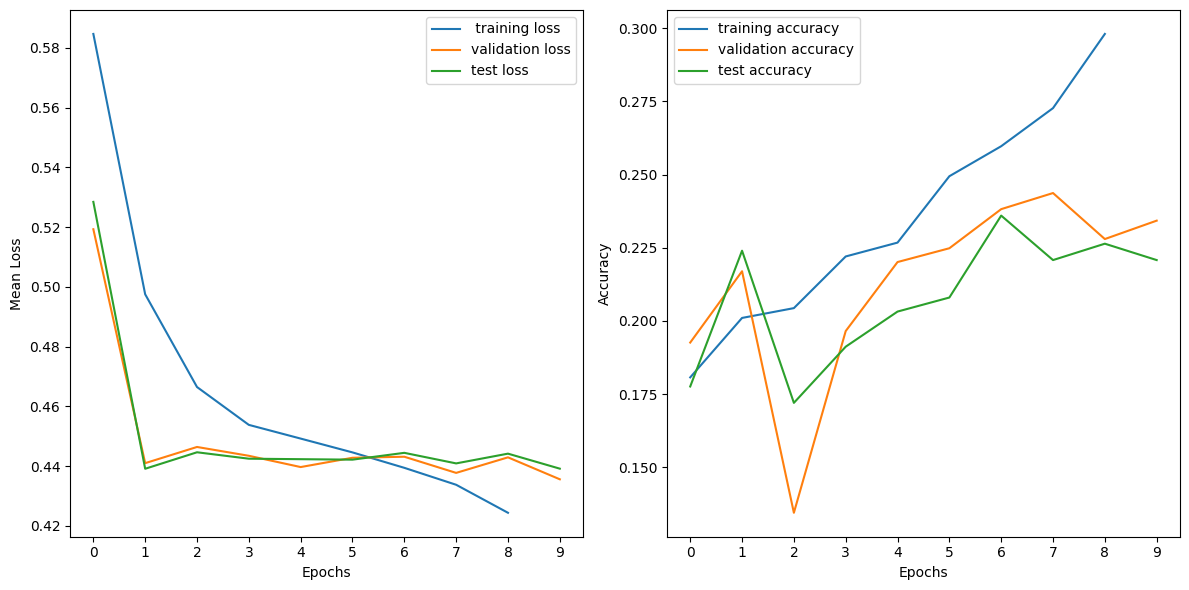

[1. 1. 1. ... 0. 1. 3.] [1. 0. 3. ... 5. 1. 0.]
Classification report of val dataset
              precision    recall  f1-score   support

         0.0       0.19      0.17      0.18       234
         1.0       0.24      0.64      0.34       262
         2.0       0.24      0.04      0.08       247
         3.0       0.27      0.31      0.29       249
         4.0       1.00      0.00      0.00       113
         5.0       0.19      0.02      0.04       167

    accuracy                           0.23      1272
   macro avg       0.35      0.20      0.15      1272
weighted avg       0.30      0.23      0.18      1272

[1. 1. 0. ... 3. 1. 0.] [5. 3. 2. ... 2. 5. 1.]
Classification report of test dataset
              precision    recall  f1-score   support

         0.0       0.19      0.18      0.19       212
         1.0       0.22      0.60      0.32       246
         2.0       0.29      0.06      0.10       260
         3.0       0.21      0.28      0.24       238
         4.0   

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class LSTMModel(nn.Module):
  def __init__(self, input_size, input_size_POS, input_size_Meta, embedding_dim, hidden_size, output_size):
    super(LSTMModel, self).__init__()
    self.word_embeddings = nn.Embedding(input_size, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)

    self.POS_word_embeddings = nn.Embedding(input_size_POS, embedding_dim)
    self.POS_lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)

    self.Meta_fc = nn.Linear(input_size_Meta, 64)
    self.Meta_dropout = nn.Dropout(p=0.5)

    self.fc1 = nn.Linear(256*hidden_size + 64, 100)
    self.dropout1 = nn.Dropout(p=0.5)
    self.fc2 = nn.Linear(100, 6)
    self.softmax = nn.Softmax()


  def forward(self, x, POS, Meta, val = False):
    # print(x.shape,POS.shape,Meta.shape)
    x = self.word_embeddings(x)
    out, (h,s) = self.lstm(x)

    # x_POS = self.POS_word_embeddings(POS)
    # out_POS, (h_POS,s_POS) = self.POS_lstm(x_POS)

    out_meta = self.Meta_dropout(nn.functional.relu(self.Meta_fc(Meta)))
    # print(out[:,-1,:].shape, out_POS[:,-1,:].shape,out_meta.shape)

    out = torch.cat([out.reshape(out.shape[0],-1),out_meta],dim=1)
    # print(out.shape)
    # print(out.shape,out.reshape(out.shape[0],-1).shape, out[:,-1,:].shape)
    out = self.dropout1(nn.functional.relu(self.fc1(out)))
    # out = self.dropout1(nn.functional.relu(self.fc1(out.reshape(out.shape[0],-1))))
    out = self.fc2(out)
    # print(out.shape)
    return self.softmax(out)

# Instantiate the model
input_size = len(vocab)
input_size_POS = len(POS_vocab)
input_size_Meta = 84

embedding_dim = 100
hidden_size = 100
output_size = 6
model = HybridCNNModel(input_size, input_size_POS, input_size_Meta, embedding_dim, hidden_size, output_size).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 10

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)

train_and_evaluate(model, criterion, optimizer, train_dataloader, val_dataloader, test_dataloader, num_epochs)

<ipython-input-17-7a7c3d3a4501>:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = torch.nn.functional.softmax(weights.squeeze(2)).unsqueeze(2)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[1] 	 val loss:0.449 	 val accuracy: 0.113 	 count: 1272
[1] 	 test loss:0.449 	 test accuracy: 0.098 	 count: 1250

[2] 	 train loss:0.444 	 train accuracy: 0.201 	 count: 10138
[2] 	 val loss:0.442 	 val accuracy: 0.233 	 count: 1272
[2] 	 test loss:0.443 	 test accuracy: 0.231 	 count: 1250

[3] 	 train loss:0.437 	 train accuracy: 0.267 	 count: 10138
[3] 	 val loss:0.442 	 val accuracy: 0.242 	 count: 1272
[3] 	 test loss:0.441 	 test accuracy: 0.247 	 count: 1250

[4] 	 train loss:0.418 	 train accuracy: 0.357 	 count: 10138
[4] 	 val loss:0.445 	 val accuracy: 0.224 	 count: 1272
[4] 	 test loss:0.443 	 test accuracy: 0.239 	 count: 1250

[5] 	 train loss:0.396 	 train accuracy: 0.461 	 count: 10138
[5] 	 val loss:0.447 	 val accuracy: 0.218 	 count: 1272
[5] 	 test loss:0.446 	 test accuracy: 0.233 	 count: 1250

[6] 	 train loss:0.376 	 train accuracy: 0.544 	 count: 10138
[6] 	 val loss:0.450 	 val accuracy: 0.223 	 count: 1272
[6] 	 test loss:0.447 	 test accuracy: 0.230 	 c

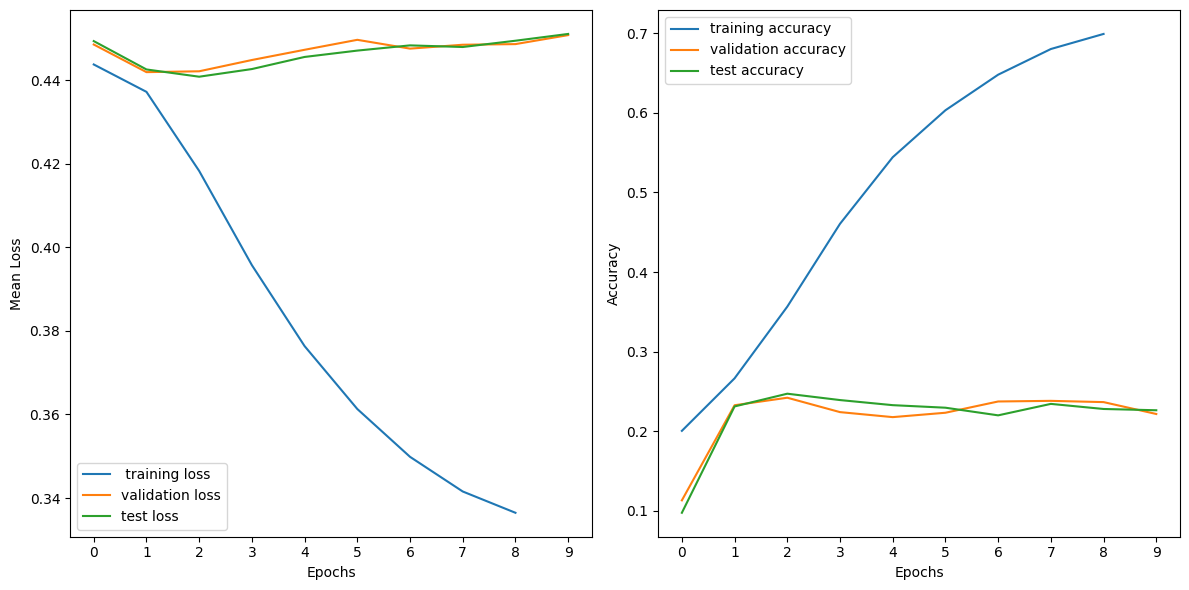

[1. 2. 0. ... 3. 3. 1.] [1. 5. 2. ... 5. 3. 2.]
Classification report of val dataset
              precision    recall  f1-score   support

         0.0       0.22      0.16      0.18       234
         1.0       0.25      0.31      0.27       262
         2.0       0.24      0.25      0.24       247
         3.0       0.27      0.29      0.28       249
         4.0       0.00      0.00      0.00       113
         5.0       0.13      0.19      0.15       167

    accuracy                           0.22      1272
   macro avg       0.18      0.20      0.19      1272
weighted avg       0.21      0.22      0.21      1272



<ipython-input-17-7a7c3d3a4501>:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = torch.nn.functional.softmax(weights.squeeze(2)).unsqueeze(2)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[2. 1. 3. ... 0. 1. 2.] [2. 1. 2. ... 2. 2. 1.]
Classification report of test dataset
              precision    recall  f1-score   support

         0.0       0.20      0.18      0.19       212
         1.0       0.25      0.27      0.26       246
         2.0       0.28      0.28      0.28       260
         3.0       0.20      0.24      0.22       238
         4.0       0.00      0.00      0.00        91
         5.0       0.19      0.25      0.21       203

    accuracy                           0.23      1250
   macro avg       0.19      0.20      0.19      1250
weighted avg       0.21      0.23      0.22      1250



In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class HybridAttentionLSTM(torch.nn.Module):
    def __init__(self, input_size, input_size_POS, input_size_Meta, embedding_dim, hidden_size, lstm_hidden_size, output_size, batch_size):

        super(HybridAttentionLSTM, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        # self.word_embeddings.weight = nn.Parameter(embeddings,requires_grad=False)
        # self.word_embeddings.weight.data.copy_(torch.from_numpy(opt.embeddings))

        self.lstm = nn.LSTM(embedding_dim, lstm_hidden_size, batch_first=True, num_layers=1, dropout=0.8, bidirectional=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax()

    def forward(self, X, POS, Meta, val = False):
        embedded = self.word_embeddings(X)
        rnn_out, (h_n, c_n) = self.lstm(embedded)

        # attention
        merged_state = torch.cat([s for s in h_n],1).squeeze(0).unsqueeze(2)
        weights = torch.bmm(rnn_out, merged_state)
        weights = torch.nn.functional.softmax(weights.squeeze(2)).unsqueeze(2)
        attn_out = torch.bmm(torch.transpose(rnn_out, 1, 2), weights).squeeze(2)

        out = self.fc(attn_out)
        return self.softmax(out)

input_size = len(vocab)
input_size_POS = len(POS_vocab)
input_size_Meta = 84

embedding_dim = 100
hidden_size = 100
output_size = 6

hidden_dim = 128
batch_size = 4
vocab_size = len(vocab)

embeddings = "glove.6b.300"

model = HybridAttentionLSTM( input_size, input_size_POS, input_size_Meta, embedding_dim, hidden_size, hidden_size // 2, output_size, batch_size)



# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 10

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)

train_and_evaluate(model, criterion, optimizer, train_dataloader, val_dataloader, test_dataloader, num_epochs)

[1] 	 val loss:0.447 	 val accuracy: 0.168 	 count: 1272
[1] 	 test loss:0.448 	 test accuracy: 0.179 	 count: 1250

[2] 	 train loss:0.446 	 train accuracy: 0.210 	 count: 10138
[2] 	 val loss:0.442 	 val accuracy: 0.208 	 count: 1272
[2] 	 test loss:0.442 	 test accuracy: 0.211 	 count: 1250

[3] 	 train loss:0.440 	 train accuracy: 0.244 	 count: 10138
[3] 	 val loss:0.443 	 val accuracy: 0.231 	 count: 1272
[3] 	 test loss:0.444 	 test accuracy: 0.237 	 count: 1250

[4] 	 train loss:0.431 	 train accuracy: 0.300 	 count: 10138
[4] 	 val loss:0.450 	 val accuracy: 0.230 	 count: 1272
[4] 	 test loss:0.449 	 test accuracy: 0.238 	 count: 1250

[5] 	 train loss:0.422 	 train accuracy: 0.346 	 count: 10138
[5] 	 val loss:0.451 	 val accuracy: 0.233 	 count: 1272
[5] 	 test loss:0.458 	 test accuracy: 0.206 	 count: 1250

[6] 	 train loss:0.420 	 train accuracy: 0.361 	 count: 10138
[6] 	 val loss:0.451 	 val accuracy: 0.237 	 count: 1272
[6] 	 test loss:0.455 	 test accuracy: 0.222 	 c

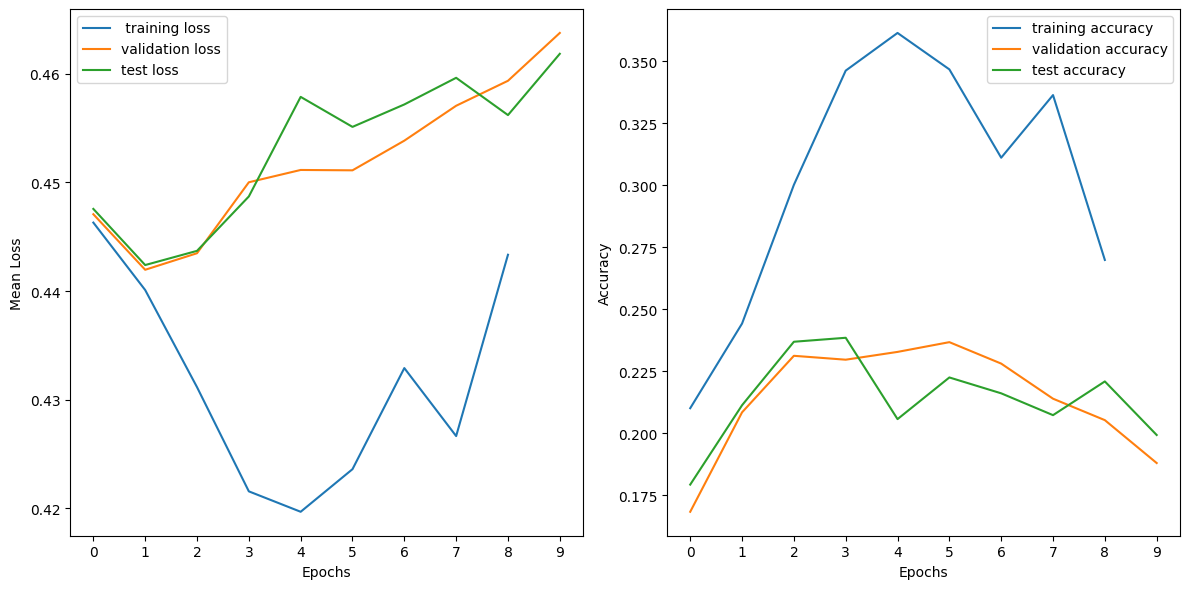

[5. 0. 5. ... 5. 5. 5.] [1. 1. 3. ... 3. 5. 2.]
Classification report of val dataset
              precision    recall  f1-score   support

         0.0       0.16      0.04      0.06       234
         1.0       0.26      0.32      0.29       262
         2.0       0.21      0.04      0.07       247
         3.0       0.15      0.07      0.09       249
         4.0       1.00      0.00      0.00       113
         5.0       0.16      0.72      0.27       167

    accuracy                           0.19      1272
   macro avg       0.32      0.20      0.13      1272
weighted avg       0.26      0.19      0.14      1272



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[5. 5. 2. ... 5. 5. 1.] [1. 0. 2. ... 5. 5. 4.]
Classification report of test dataset
              precision    recall  f1-score   support

         0.0       0.22      0.04      0.06       212
         1.0       0.21      0.27      0.24       246
         2.0       0.29      0.05      0.09       260
         3.0       0.24      0.13      0.17       238
         4.0       1.00      0.00      0.00        91
         5.0       0.18      0.65      0.28       203

    accuracy                           0.20      1250
   macro avg       0.36      0.19      0.14      1250
weighted avg       0.29      0.20      0.15      1250



In [ ]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class SelfAttentionLSTM(torch.nn.Module):
    def __init__(self, input_size, input_size_POS, input_size_Meta, embedding_dim, hidden_size, lstm_hidden_size, output_size, batch_size):

        super(SelfAttentionLSTM, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        # self.word_embeddings.weight = nn.Parameter(embeddings,requires_grad=False)
        # self.word_embeddings.weight.data.copy_(torch.from_numpy(opt.embeddings))

        self.lstm = nn.LSTM(embedding_dim, lstm_hidden_size, batch_first=True, num_layers=1, dropout=0.8, bidirectional=True)
        self.multihead_attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=1)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax()

    def forward(self, X, POS, Meta, val = False):
        embedded = self.word_embeddings(X)
        rnn_out, (h_n, c_n) = self.lstm(embedded)
        rnn_out = rnn_out.permute(1, 0, 2)
        attn_out, _ = self.multihead_attention(rnn_out, rnn_out, rnn_out)
        attn_out = attn_out.permute(1, 0, 2)
        attn_out = torch.sum(attn_out, dim=1)

        out = self.fc(attn_out)
        return self.softmax(out)

input_size = len(vocab)
input_size_POS = len(POS_vocab)
input_size_Meta = 84

embedding_dim = 100
hidden_size = 100
output_size = 6

hidden_dim = 128
batch_size = 4
vocab_size = len(vocab)

embeddings = "glove.6b.300"

model = SelfAttentionLSTM( input_size, input_size_POS, input_size_Meta, embedding_dim, hidden_dim, hidden_dim // 2, output_size, batch_size)


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 10

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)

train_and_evaluate(model, criterion, optimizer, train_dataloader, val_dataloader, test_dataloader, num_epochs)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
<ipython-input-6-e3aad740d285>:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = torch.nn.functional.softmax(weights.squeeze(2)).unsqueeze(2)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[1] 	 val loss:0.448 	 val accuracy: 0.142 	 count: 1272
[1] 	 test loss:0.449 	 test accuracy: 0.172 	 count: 1250

[2] 	 train loss:0.443 	 train accuracy: 0.220 	 count: 10138
[2] 	 val loss:0.439 	 val accuracy: 0.247 	 count: 1272
[2] 	 test loss:0.440 	 test accuracy: 0.241 	 count: 1250

[3] 	 train loss:0.433 	 train accuracy: 0.277 	 count: 10138
[3] 	 val loss:0.440 	 val accuracy: 0.233 	 count: 1272
[3] 	 test loss:0.442 	 test accuracy: 0.231 	 count: 1250

[4] 	 train loss:0.420 	 train accuracy: 0.345 	 count: 10138
[4] 	 val loss:0.442 	 val accuracy: 0.248 	 count: 1272
[4] 	 test loss:0.442 	 test accuracy: 0.249 	 count: 1250

[5] 	 train loss:0.399 	 train accuracy: 0.435 	 count: 10138
[5] 	 val loss:0.445 	 val accuracy: 0.241 	 count: 1272
[5] 	 test loss:0.446 	 test accuracy: 0.239 	 count: 1250

[6] 	 train loss:0.384 	 train accuracy: 0.505 	 count: 10138
[6] 	 val loss:0.448 	 val accuracy: 0.227 	 count: 1272
[6] 	 test loss:0.446 	 test accuracy: 0.242 	 c

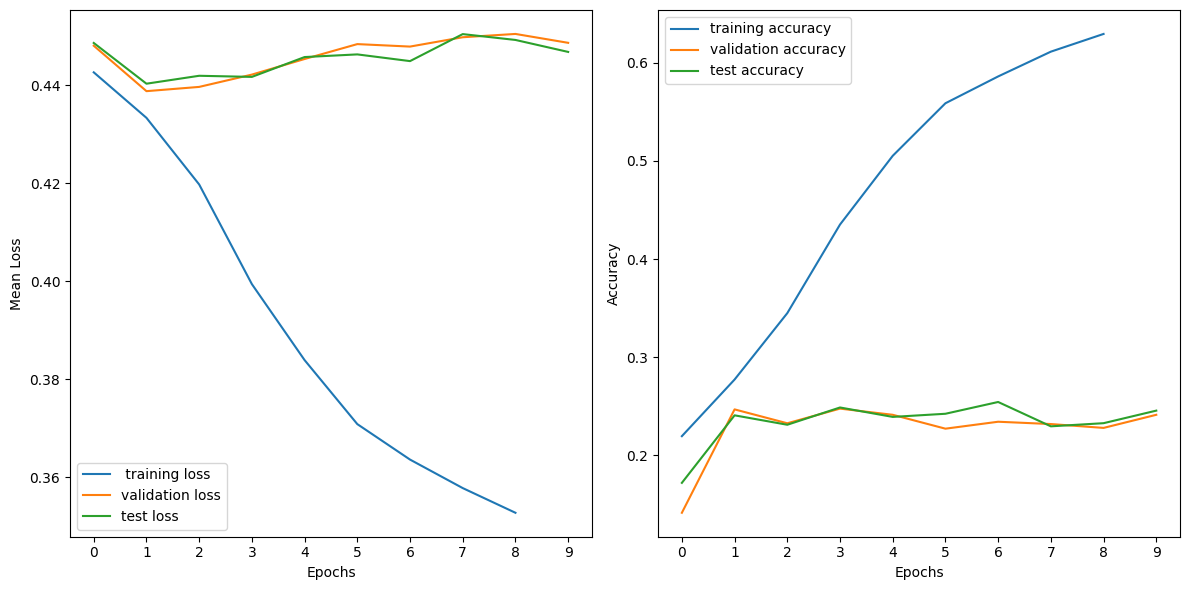

[5. 1. 1. ... 0. 2. 2.] [4. 5. 0. ... 0. 3. 3.]
Classification report of val dataset
              precision    recall  f1-score   support

         0.0       0.20      0.15      0.17       234
         1.0       0.27      0.42      0.33       262
         2.0       0.25      0.27      0.26       247
         3.0       0.29      0.23      0.26       249
         4.0       1.00      0.00      0.00       113
         5.0       0.17      0.23      0.20       167

    accuracy                           0.24      1272
   macro avg       0.36      0.22      0.20      1272
weighted avg       0.31      0.24      0.22      1272



<ipython-input-6-e3aad740d285>:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = torch.nn.functional.softmax(weights.squeeze(2)).unsqueeze(2)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[1. 1. 5. ... 1. 2. 2.] [2. 2. 1. ... 2. 5. 3.]
Classification report of test dataset
              precision    recall  f1-score   support

         0.0       0.18      0.13      0.15       212
         1.0       0.24      0.40      0.30       246
         2.0       0.30      0.31      0.30       260
         3.0       0.25      0.19      0.22       238
         4.0       1.00      0.00      0.00        91
         5.0       0.23      0.27      0.25       203

    accuracy                           0.25      1250
   macro avg       0.37      0.22      0.20      1250
weighted avg       0.30      0.25      0.23      1250



In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class HybridAttentionLSTM(torch.nn.Module):
    def __init__(self, input_size, input_size_POS, input_size_Meta, embedding_dim, hidden_size, lstm_hidden_size, output_size, batch_size):

        super(HybridAttentionLSTM, self).__init__()
        self.word_embeddings = nn.Embedding(input_size, embedding_dim)

        self.lstm = nn.LSTM(embedding_dim, lstm_hidden_size, batch_first=True, num_layers=1, dropout=0.8, bidirectional=True)
        self.Meta_fc = nn.Linear(input_size_Meta, 64)
        self.Meta_dropout = nn.Dropout(p=0.5)

        self.POS_word_embeddings = nn.Embedding(input_size_POS, embedding_dim)
        self.POS_lstm = nn.LSTM(embedding_dim, lstm_hidden_size, batch_first=True, num_layers=1, dropout=0.8, bidirectional=True)

        self.fc1 = nn.Linear(hidden_size*2 + 64, 100)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(100, output_size)
        self.softmax = nn.Softmax()

    def forward(self, X, POS, Meta, val = False):
        embedded = self.word_embeddings(X)
        rnn_out, (h_n, c_n) = self.lstm(embedded)

        embedded_POS = self.POS_word_embeddings(POS)
        rnn_POS, (h_POS,s_POS) = self.POS_lstm(embedded_POS)

        rnn_out = torch.cat([rnn_out,rnn_POS],dim = 2)
        h_n = torch.cat([h_n, h_POS], dim = 0)

        # attention
        merged_state = torch.cat([s for s in h_n],1).squeeze(0).unsqueeze(2)
        weights = torch.bmm(rnn_out, merged_state)
        weights = torch.nn.functional.softmax(weights.squeeze(2)).unsqueeze(2)
        attn_out = torch.bmm(torch.transpose(rnn_out, 1, 2), weights).squeeze(2)

        out_meta = self.Meta_dropout(nn.functional.relu(self.Meta_fc(Meta)))
        out = torch.cat([attn_out,out_meta],dim=1)

        out = self.dropout1(nn.functional.relu(self.fc1(out)))
        # out = self.dropout1(nn.functional.relu(self.fc1(out.reshape(out.shape[0],-1))))
        out = self.fc2(out)
        # print(out.shape)
        return self.softmax(out)

input_size = len(vocab)
input_size_POS = len(POS_vocab)
input_size_Meta = 84

embedding_dim = 100
hidden_size = 100
output_size = 6

hidden_dim = 128
batch_size = 4
vocab_size = len(vocab)

embeddings = "glove.6b.300"

model = HybridAttentionLSTM( input_size, input_size_POS, input_size_Meta, embedding_dim, hidden_size, hidden_size // 2, output_size, batch_size)



# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 10

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)

train_and_evaluate(model, criterion, optimizer, train_dataloader, val_dataloader, test_dataloader, num_epochs)

[1] 	 val loss:0.455 	 val accuracy: 0.195 	 count: 1272
[1] 	 test loss:0.458 	 test accuracy: 0.189 	 count: 1250

[2] 	 train loss:0.545 	 train accuracy: 0.194 	 count: 10138
[2] 	 val loss:0.445 	 val accuracy: 0.216 	 count: 1272
[2] 	 test loss:0.445 	 test accuracy: 0.203 	 count: 1250

[3] 	 train loss:0.516 	 train accuracy: 0.206 	 count: 10138
[3] 	 val loss:0.444 	 val accuracy: 0.208 	 count: 1272
[3] 	 test loss:0.444 	 test accuracy: 0.195 	 count: 1250

[4] 	 train loss:0.507 	 train accuracy: 0.222 	 count: 10138
[4] 	 val loss:0.446 	 val accuracy: 0.223 	 count: 1272
[4] 	 test loss:0.442 	 test accuracy: 0.223 	 count: 1250

[5] 	 train loss:0.486 	 train accuracy: 0.239 	 count: 10138
[5] 	 val loss:0.453 	 val accuracy: 0.212 	 count: 1272
[5] 	 test loss:0.453 	 test accuracy: 0.206 	 count: 1250

[6] 	 train loss:0.467 	 train accuracy: 0.265 	 count: 10138
[6] 	 val loss:0.446 	 val accuracy: 0.213 	 count: 1272
[6] 	 test loss:0.439 	 test accuracy: 0.231 	 c

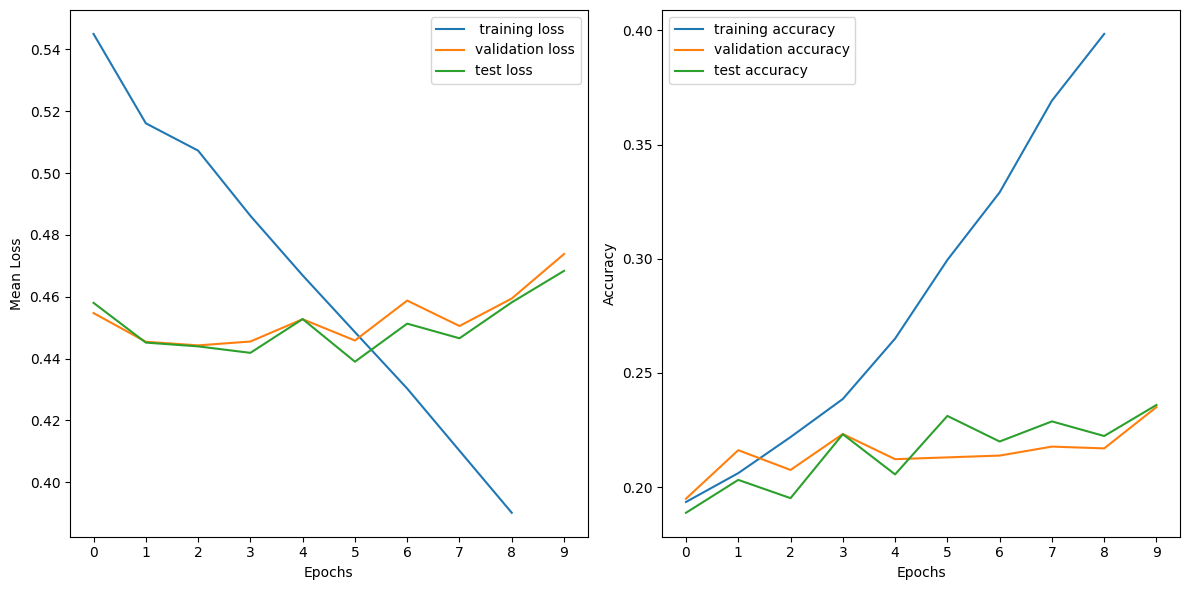

[1. 1. 1. ... 3. 3. 1.] [5. 1. 5. ... 0. 3. 2.]
Classification report of val dataset
              precision    recall  f1-score   support

         0.0       0.26      0.08      0.12       234
         1.0       0.24      0.50      0.33       262
         2.0       0.26      0.27      0.26       247
         3.0       0.21      0.21      0.21       249
         4.0       0.20      0.03      0.05       113
         5.0       0.20      0.17      0.18       167

    accuracy                           0.24      1272
   macro avg       0.23      0.21      0.19      1272
weighted avg       0.23      0.24      0.21      1272

[5. 2. 2. ... 5. 1. 2.] [3. 3. 3. ... 0. 3. 1.]
Classification report of test dataset
              precision    recall  f1-score   support

         0.0       0.20      0.06      0.09       212
         1.0       0.23      0.49      0.32       246
         2.0       0.28      0.26      0.27       260
         3.0       0.21      0.23      0.22       238
         4.0   

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class HybridCNNModel(nn.Module):
  def __init__(self, input_size, input_size_POS, input_size_Meta, embedding_dim, hidden_size, output_size):
    super(HybridCNNModel, self).__init__()
    self.word_embeddings = nn.Embedding(input_size, embedding_dim)
    filter_sizes = [2,3,4]
    self.convs = nn.ModuleList([
      nn.Sequential(
        nn.Conv1d(in_channels=100, out_channels=128, kernel_size=fs),
        nn.ReLU(),
        nn.Dropout(p=0.8)
      ) for fs in filter_sizes
    ])
    # self.fc = nn.Linear(len(filter_sizes) * 128, output_size)
    self.fc = nn.Linear(128+128+128, output_size)
    self.softmax = nn.Softmax()


  def forward(self, x, POS, Meta, val = False):
    x = self.word_embeddings(x)
    x = x.permute(0, 2, 1)
    # print(x.shape)
    x = [nn.functional.relu(conv(x)) for conv in self.convs]
    # print([xi.shape for xi in x])
    x = [nn.functional.max_pool1d(conv, conv.size(2)).squeeze(2) for conv in x]
    # print([xi.shape for xi in x])
    x = torch.cat(x, 1)
    x = self.fc(x)
    return x


# Instantiate the model
input_size = len(vocab)
input_size_POS = len(POS_vocab)
input_size_Meta = 84

embedding_dim = 100
hidden_size = 100
output_size = 6
model = HybridCNNModel(input_size, input_size_POS, input_size_Meta, embedding_dim, hidden_size, output_size).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 10

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)

train_and_evaluate(model, criterion, optimizer, train_dataloader, val_dataloader, test_dataloader, num_epochs)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
<ipython-input-9-921439c563f7>:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = torch.nn.functional.softmax(weights.squeeze(2)).unsqueeze(2)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[1] 	 val loss:0.448 	 val accuracy: 0.137 	 count: 1272
[1] 	 test loss:0.449 	 test accuracy: 0.168 	 count: 1250

[2] 	 train loss:0.444 	 train accuracy: 0.207 	 count: 10138
[2] 	 val loss:0.441 	 val accuracy: 0.231 	 count: 1272
[2] 	 test loss:0.441 	 test accuracy: 0.230 	 count: 1250

[3] 	 train loss:0.438 	 train accuracy: 0.253 	 count: 10138
[3] 	 val loss:0.439 	 val accuracy: 0.253 	 count: 1272
[3] 	 test loss:0.441 	 test accuracy: 0.245 	 count: 1250

[0.44389511021337325, 0.43785816862588334] [array(0.20664826, dtype=float32), array(0.2525153, dtype=float32)]
[0.4482615147746584, 0.4408755398958734, 0.4385105952526788] [array(0.13679245, dtype=float32), array(0.23113208, dtype=float32), array(0.25314465, dtype=float32)]
[0.4486870678901672, 0.44078553619384764, 0.44052154874801636] [array(0.168, dtype=float32), array(0.2304, dtype=float32), array(0.2448, dtype=float32)]
[0.44389511 0.43785817] [0.20664826 0.2525153 ]
[0.44826151 0.44087554 0.4385106 ] [0.13679245 0.

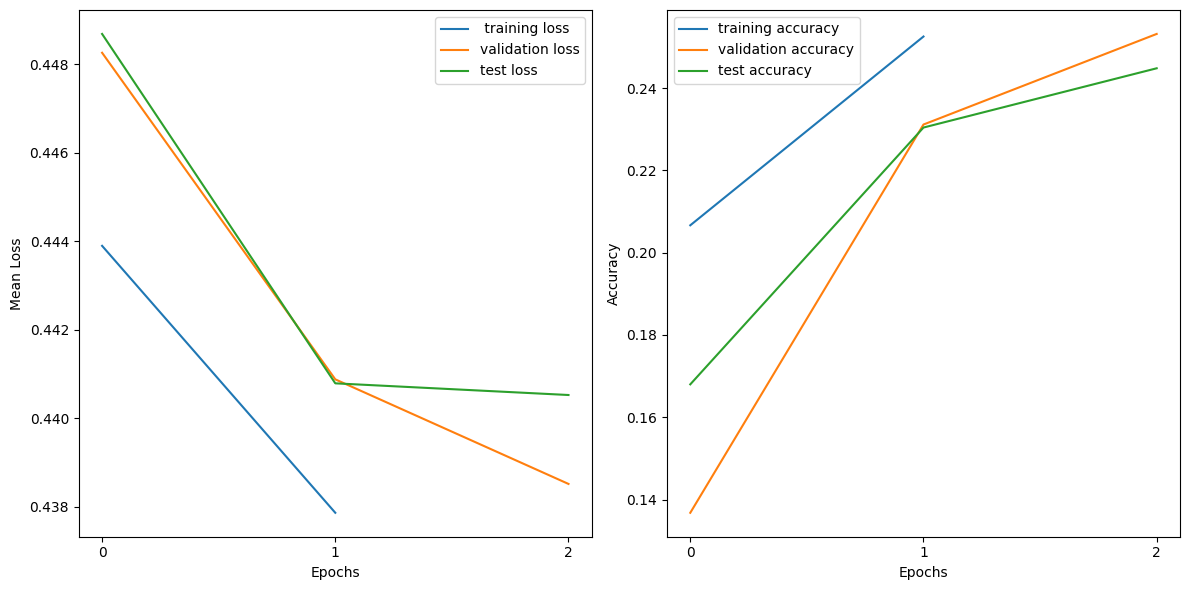

[2. 1. 3. ... 2. 2. 1.] [1. 0. 1. ... 5. 1. 1.]
Classification report of val dataset
              precision    recall  f1-score   support

         0.0       1.00      0.00      0.00       234
         1.0       0.27      0.47      0.34       262
         2.0       0.24      0.37      0.29       247
         3.0       0.26      0.40      0.32       249
         4.0       1.00      0.00      0.00       113
         5.0       0.14      0.04      0.06       167

    accuracy                           0.25      1272
   macro avg       0.49      0.21      0.17      1272
weighted avg       0.44      0.25      0.20      1272



<ipython-input-9-921439c563f7>:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = torch.nn.functional.softmax(weights.squeeze(2)).unsqueeze(2)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[1. 1. 5. ... 3. 3. 3.] [3. 2. 3. ... 2. 3. 3.]
Classification report of test dataset
              precision    recall  f1-score   support

         0.0       1.00      0.00      0.00       212
         1.0       0.26      0.43      0.33       246
         2.0       0.24      0.38      0.29       260
         3.0       0.25      0.41      0.31       238
         4.0       1.00      0.00      0.00        91
         5.0       0.09      0.02      0.03       203

    accuracy                           0.24      1250
   macro avg       0.47      0.21      0.16      1250
weighted avg       0.41      0.24      0.19      1250



In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class HybridAttentionLSTM(torch.nn.Module):
    def __init__(self, input_size, input_size_POS, input_size_Meta, embedding_dim, hidden_size, lstm_hidden_size, output_size, batch_size):

        super(HybridAttentionLSTM, self).__init__()
        self.word_embeddings = nn.Embedding(input_size, embedding_dim)

        self.lstm = nn.LSTM(embedding_dim, lstm_hidden_size, batch_first=True, num_layers=1, dropout=0.8, bidirectional=True)
        self.Meta_fc = nn.Linear(input_size_Meta, 64)
        self.Meta_dropout = nn.Dropout(p=0.5)

        self.POS_word_embeddings = nn.Embedding(input_size_POS, embedding_dim)
        self.POS_lstm = nn.LSTM(embedding_dim, lstm_hidden_size, batch_first=True, num_layers=1, dropout=0.8, bidirectional=True)

        self.fc1 = nn.Linear(hidden_size*2 + 64, 100)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(100, output_size)
        self.softmax = nn.Softmax()

    def forward(self, X, POS, Meta, val = False):
        embedded = self.word_embeddings(X)
        rnn_out, (h_n, c_n) = self.lstm(embedded)

        embedded_POS = self.POS_word_embeddings(POS)
        rnn_POS, (h_POS,s_POS) = self.POS_lstm(embedded_POS)

        rnn_out = torch.cat([rnn_out,rnn_POS],dim = 2)
        h_n = torch.cat([h_n, h_POS], dim = 0)

        # attention
        merged_state = torch.cat([s for s in h_n],1).squeeze(0).unsqueeze(2)
        weights = torch.bmm(rnn_out, merged_state)
        weights = torch.nn.functional.softmax(weights.squeeze(2)).unsqueeze(2)
        attn_out = torch.bmm(torch.transpose(rnn_out, 1, 2), weights).squeeze(2)

        out_meta = self.Meta_dropout(nn.functional.relu(self.Meta_fc(Meta)))
        out = torch.cat([attn_out,out_meta],dim=1)

        out = self.dropout1(nn.functional.relu(self.fc1(out)))
        # out = self.dropout1(nn.functional.relu(self.fc1(out.reshape(out.shape[0],-1))))
        out = self.fc2(out)
        # print(out.shape)
        return self.softmax(out)

input_size = len(vocab)
input_size_POS = len(POS_vocab)
input_size_Meta = 84

embedding_dim = 100
hidden_size = 100
output_size = 6

hidden_dim = 128
batch_size = 4
vocab_size = len(vocab)

embeddings = "glove.6b.300"

model = HybridAttentionLSTM( input_size, input_size_POS, input_size_Meta, embedding_dim, hidden_size, hidden_size // 2, output_size, batch_size)




# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 3

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)

train_and_evaluate(model, criterion, optimizer, train_dataloader, val_dataloader, test_dataloader, num_epochs)

torch.save(model.state_dict(), 'model.pth')